In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

In [5]:
#2 Load Dataset 
df = pd.read_csv("Dataset.csv")

print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (45593, 11)

Missing Values:
 ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Delivery Time_taken(min)       0
dtype: int64


In [7]:
#3 Feature engineering
#Haversine Distance Function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["distance_km"] = haversine(
    df["Restaurant_latitude"],
    df["Restaurant_longitude"],
    df["Delivery_location_latitude"],
    df["Delivery_location_longitude"]
)

# Remove unrealistic distance outliers
df = df[df["distance_km"] < 50]

In [8]:
#4 CLEANING

# Drop IDs: not necessary in prediction
df = df.drop(["ID", "Delivery_person_ID"], axis=1)

# Drop latitude/longitude after distance creation
df = df.drop([
    "Restaurant_latitude",
    "Restaurant_longitude",
    "Delivery_location_latitude",
    "Delivery_location_longitude"
], axis=1)

# One-hot encoding
df = pd.get_dummies(df, columns=["Type_of_order", "Type_of_vehicle"], drop_first=True)

In [9]:
#5. DEFINING FEATURES & TARGET VARIABLE

y = df["Delivery Time_taken(min)"]
X = df.drop("Delivery Time_taken(min)", axis=1)

In [10]:
# 6. TRAIN TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [11]:
#7. MODEL TRAINING

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression MAE:",
      round(mean_absolute_error(y_test, y_pred_lr), 2))


# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest MAE:",
      round(mean_absolute_error(y_test, y_pred_rf), 2))


# Gradient Boosting (Final Model)
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print("Gradient Boosting MAE:", round(mae_gb, 2))
print("Gradient Boosting RMSE:", round(rmse_gb, 2))

Linear Regression MAE: 6.32
Random Forest MAE: 6.08
Gradient Boosting MAE: 5.68
Gradient Boosting RMSE: 7.24


In [12]:
# 8. CROSS VALIDATION

cv_scores = cross_val_score(
    gb,
    X,
    y,
    scoring='neg_mean_absolute_error',
    cv=5
)

print("Cross Val MAE:", round(-np.mean(cv_scores), 2))

Cross Val MAE: 5.68


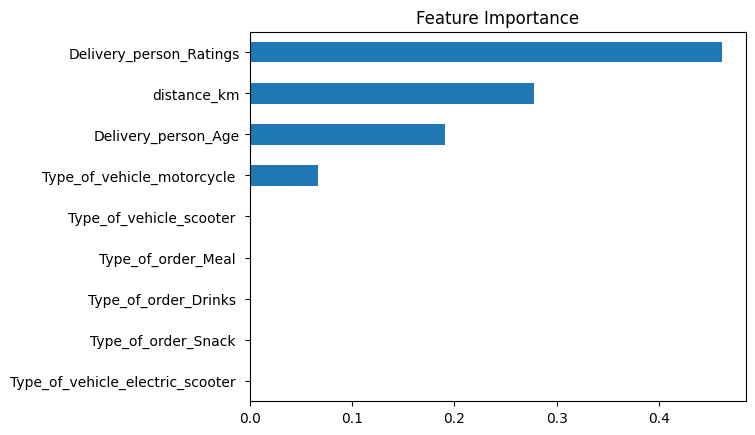

In [13]:
#9. FEATURE IMPORTANCE

feature_importance = pd.Series(gb.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [14]:
# 10. SAVE MODEL

joblib.dump(gb, "delivery_time_model.pkl")

['delivery_time_model.pkl']